In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import yahoo_fin.stock_info as si
import matplotlib.pyplot as plt
from binance.client import Client

In [2]:
tickers = ['BTC']
start_date = '2023-01-01'
end_date = '2023-08-02'

In [3]:
def load_data(tickers):
    try:
        data = pd.DataFrame()
        for ticker in tickers:
            data["Close"] = yf.download(ticker, start_date, end_date)['Close']
        return data
    except Exception as e:
        print(f'An exception occurred while executing load_data: {e}')

def load_data_binance(tickets):
    try:
        api_key = 'zQQmi6JI31vLt3tZSCet7dvrET2Qg5pq3PcxqCsrzb5Hl4f6sI4IoYduKIGNCIwX'
        api_secret = 'TGId4L8bw5ClniGSzdrKHHe1uwEizLdft3A59Ks6fP4bKz824OHg9sPChngmhL2t'
        client = Client(api_key, api_secret)
        data = np.array(client.get_historical_klines(symbol=tickets, interval=client.KLINE_INTERVAL_1MINUTE))
        df = pd.DataFrame(data.reshape(-1,12),dtype=float, columns = ('Open Time',
                                                                        'Open',
                                                                        'High',
                                                                        'Low',
                                                                        'Close',
                                                                        'Volume',
                                                                        'Close time',
                                                                        'Quote asset volume',
                                                                        'Number of trades',
                                                                        'Taker buy base asset volume',
                                                                        'Taker buy quote asset volume',
                                                                        'Ignore'))
        df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
        return df
    except Exception as e:
        print(f'An exception occurred while executing load_data_binance: {e}')

def find_buy_sell_signals(df):
    upper_band = df['Upper']
    lower_band = df['Lower']
    close_prices = df['Close']
    
    buy_signals, sell_signals = pd.DataFrame(), pd.DataFrame()
    buy_signals['Close'] = close_prices[close_prices < lower_band]
    sell_signals['Close'] = close_prices[close_prices > upper_band]    
    return buy_signals, sell_signals

In [4]:
# close = load_data_binance("BNBBTC")
# close = close["Close"]
close = load_data(tickers)

sma = close.rolling(window=30).mean().dropna()
rstd = close.rolling(window=30).std().dropna()

upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

upper_band = upper_band.rename(columns={'Close': 'Upper'})
lower_band = lower_band.rename(columns={'Close': 'Lower'})
df_bollinger_band = close.join(upper_band).join(lower_band)
df_bollinger_band = df_bollinger_band.dropna()

buyers, sellers = find_buy_sell_signals(df_bollinger_band)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: No data found for this date range, symbol may be delisted


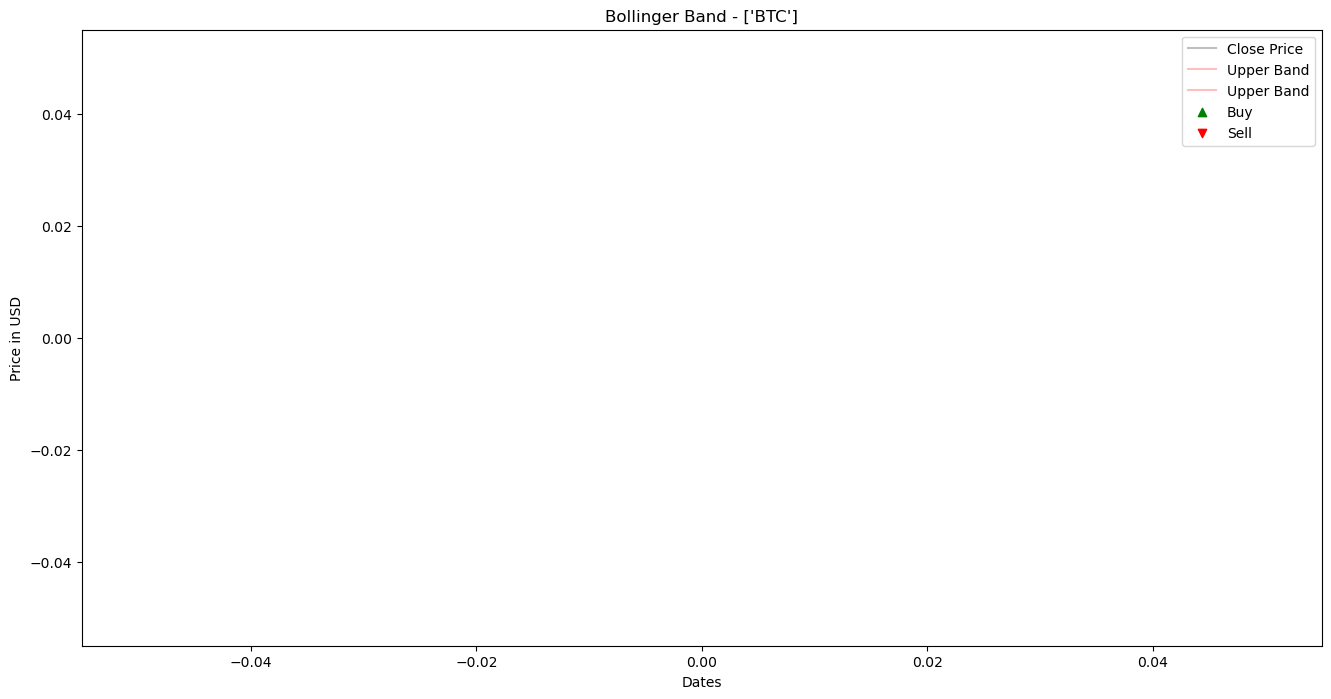

In [5]:
fig, ax = plt.subplots(figsize=(16,8))
plt.title(f'Bollinger Band - {tickers}')
plt.ylabel('Price in USD')
plt.xlabel('Dates')
ax.plot(close['Close'], label = 'Close Price', alpha = 0.25, color = 'black')
ax.plot(df_bollinger_band['Upper'], label = 'Upper Band', alpha = 0.25, color = 'red')
ax.plot(df_bollinger_band['Lower'], label = 'Upper Band', alpha = 0.25, color = 'red')
ax.scatter(buyers.index, buyers['Close'], label = 'Buy', alpha = 1, marker = '^', color = 'green')
ax.scatter(sellers.index, sellers['Close'], label = 'Sell', alpha = 1, marker = 'v', color = 'red')
plt.legend()
plt.show()